In [41]:
# !pip install scikit-learn
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib

# Windows용 한글 폰트 설정 (맑은 고딕)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 한글폰트 예시

plt.rcParams['axes.unicode_minus'] = True  # 음수 기호 제대로 표시 설정

import warnings
warnings.filterwarnings('ignore')

tm=연도월일시

line=호선 / station_number: 역 번호 / station_name: 역명 / direction: 상/하행

stn: 지하철 역 코드

ta: 기온 / wd: 풍향 / ws: 풍속

rn_day: 일 강수량 / rn_hr1: 1시간 강수량

hm: 상대습도/ si: 일조량 / ta_chi: 체감 온도

congestion: 혼잡도(높을수록 혼잡)

# 혼잡도 관련 가설
1. 기온, 체감온도, 일조량이 높으면 혼잡도가 증가할 것이다
2. 일강수량, 1h강수량, 상대습도가 높으면 혼잡도가 증가할 것이다.
3. 일시 관련(월/일/시 구분하기)
    1) 방학(1,2,7,8월)에는 혼잡도가 다소 감소할 것이다. -> [month==1,2,7,8]==0, 나머지 1로 인코딩 해보기
    2) 출퇴근(07~09_17-19시)에는 혼잡도가 증가할 것이다. -> [hour==07,08,09,17,18,19]==1, 나머지 0으로 인코딩해보기
    3) 여러 호선이 맞물린 역은 혼잡도가 증가할 것이다.
4. (서울시 공공데이터)승하차 승객 수 -> 인기역에 해당하는 역에 라벨 인코딩 -> 분석에 추가 시도
5. 대부분의 min값(기온~체감온도)가 -99다 -> -99와 -9.9 == 결측값
6. 

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
df = pd.read_csv('train_subway23.csv')  # 파일 경로에 맞게 수정

# 데이터 상위 5개 행 확인
df.head()

,Unnamed: 0,train_subway23.tm,train_subway23.line,train_subway23.station_number,train_subway23.station_name,train_subway23.direction,train_subway23.stn,train_subway23.ta,train_subway23.wd,train_subway23.ws,train_subway23.rn_day,train_subway23.rn_hr1,train_subway23.hm,train_subway23.si,train_subway23.ta_chi,train_subway23.congestion
0,1,2023010100,1,150,서울역,상선,419,0.3,318.0,3.4,0.0,0.0,66.5,-99.0,0.7,0
1,2,2023010101,1,150,서울역,상선,419,0.6,293.8,3.4,0.0,0.0,67.5,-99.0,-0.6,0
2,3,2023010105,1,150,서울역,상선,419,-0.8,29.6,3.7,0.0,0.0,55.1,-99.0,-2.2,3
3,4,2023010106,1,150,서울역,상선,419,-1.8,48.1,3.4,0.0,0.0,62.8,-99.0,-4.0,6
4,5,2023010107,1,150,서울역,상선,419,-2.6,21.4,2.9,0.0,0.0,68.8,-99.0,-2.8,5


In [43]:
# 1. 정수형을 문자열로 변환
df['train_subway23.tm'] = df['train_subway23.tm'].astype(str)

# 2. 문자열에서 연, 월, 일, 시 분리
df['year'] = df['train_subway23.tm'].str[:4].astype('int64')
df['month'] = df['train_subway23.tm'].str[4:6].astype('int64')
df['day'] = df['train_subway23.tm'].str[6:8].astype('int64')
df['hour'] = df['train_subway23.tm'].str[8:10].astype('int64')

df.drop(columns=['train_subway23.tm'])

,Unnamed: 0,train_subway23.line,train_subway23.station_number,train_subway23.station_name,train_subway23.direction,train_subway23.stn,train_subway23.ta,train_subway23.wd,train_subway23.ws,train_subway23.rn_day,train_subway23.rn_hr1,train_subway23.hm,train_subway23.si,train_subway23.ta_chi,train_subway23.congestion,year,month,day,hour
0,1,1,150,서울역,상선,419,0.3,318.0,3.4,0.0,0.0,66.5,-99.0,0.7,0,2023,1,1,0
1,2,1,150,서울역,상선,419,0.6,293.8,3.4,0.0,0.0,67.5,-99.0,-0.6,0,2023,1,1,1
2,3,1,150,서울역,상선,419,-0.8,29.6,3.7,0.0,0.0,55.1,-99.0,-2.2,3,2023,1,1,5
3,4,1,150,서울역,상선,419,-1.8,48.1,3.4,0.0,0.0,62.8,-99.0,-4.0,6,2023,1,1,6
4,5,1,150,서울역,상선,419,-2.6,21.4,2.9,0.0,0.0,68.8,-99.0,-2.8,5,2023,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520976,5520977,8,2828,남위례,하선,572,0.6,0.0,0.0,7.0,0.0,83.1,-99.0,0.0,18,2023,12,31,19
5520977,5520978,8,2828,남위례,하선,572,0.0,354.7,0.0,7.0,0.0,84.7,-99.0,-0.6,17,2023,12,31,20
5520978,5520979,8,2828,남위례,하선,572,-0.6,0.0,0.0,7.0,0.0,85.1,-99.0,-1.1,21,2023,12,31,21
5520979,5520980,8,2828,남위례,하선,572,-0.8,0.0,0.0,7.0,0.0,85.6,-99.0,-1.3,18,2023,12,31,22


In [44]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520981 entries, 0 to 5520980
Data columns (total 20 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   train_subway23.tm              object 
 2   train_subway23.line            int64  
 3   train_subway23.station_number  int64  
 4   train_subway23.station_name    object 
 5   train_subway23.direction       object 
 6   train_subway23.stn             int64  
 7   train_subway23.ta              float64
 8   train_subway23.wd              float64
 9   train_subway23.ws              float64
 10  train_subway23.rn_day          float64
 11  train_subway23.rn_hr1          float64
 12  train_subway23.hm              float64
 13  train_subway23.si              float64
 14  train_subway23.ta_chi          float64
 15  train_subway23.congestion      int64  
 16  year                           int64  
 17  month                          int64  
 18  da

In [45]:
# 기술 통계 확인
df.describe(include='all')

,Unnamed: 0,train_subway23.tm,train_subway23.line,train_subway23.station_number,train_subway23.station_name,train_subway23.direction,train_subway23.stn,train_subway23.ta,train_subway23.wd,train_subway23.ws,train_subway23.rn_day,train_subway23.rn_hr1,train_subway23.hm,train_subway23.si,train_subway23.ta_chi,train_subway23.congestion,year,month,day,hour
count,5.520981e+06,5520981,5.520981e+06,5.520981e+06,5520981,5520981,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5.520981e+06,5520981.0,5.520981e+06,5.520981e+06,5.520981e+06
unique,NaN,7644,NaN,NaN,324,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2023123123,NaN,NaN,종로3가,하선,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,728,NaN,NaN,45864,2424155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.760491e+06,NaN,4.115205e+00,1.731644e+03,NaN,NaN,4.288204e+02,1.185897e+01,1.789502e+02,-3.535855e-01,-2.882492e-01,-2.498647e+00,6.116927e+01,-3.655811e+01,1.448298e+01,2.528324e+01,2023.0,6.537710e+00,1.573086e+01,1.271429e+01
std,1.593770e+06,NaN,2.200325e+00,1.207969e+03,NaN,NaN,1.412612e+02,1.893434e+01,1.098136e+02,1.401717e+01,1.863930e+01,1.609310e+01,3.109998e+01,4.848821e+01,1.196809e+01,2.115118e+01,0.0,3.448572e+00,8.807249e+00,6.547575e+00
min,1.000000e+00,NaN,1.000000e+00,1.500000e+02,NaN,NaN,9.800000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,-9.900000e+01,0.000000e+00,2023.0,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.380246e+06,NaN,2.000000e+00,4.090000e+02,NaN,NaN,4.070000e+02,4.500000e+00,8.710000e+01,7.000000e-01,0.000000e+00,0.000000e+00,4.690000e+01,-9.900000e+01,4.600000e+00,1.000000e+01,2023.0,4.000000e+00,8.000000e+00,8.000000e+00
50%,2.760491e+06,NaN,4.000000e+00,1.907000e+03,NaN,NaN,4.180000e+02,1.520000e+01,1.952000e+02,1.400000e+00,0.000000e+00,0.000000e+00,6.420000e+01,1.300000e-01,1.580000e+01,2.200000e+01,2023.0,7.000000e+00,1.600000e+01,1.300000e+01
75%,4.140736e+06,NaN,6.000000e+00,2.632000e+03,NaN,NaN,4.350000e+02,2.320000e+01,2.724000e+02,2.200000e+00,0.000000e+00,0.000000e+00,8.190000e+01,1.200000e+00,2.510000e+01,3.500000e+01,2023.0,1.000000e+01,2.300000e+01,1.800000e+01


In [46]:
# 결측치 확인 -> 결측치 없음
df.isnull().sum()

Unnamed: 0                       0
train_subway23.tm                0
train_subway23.line              0
train_subway23.station_number    0
train_subway23.station_name      0
train_subway23.direction         0
train_subway23.stn               0
train_subway23.ta                0
train_subway23.wd                0
train_subway23.ws                0
train_subway23.rn_day            0
train_subway23.rn_hr1            0
train_subway23.hm                0
train_subway23.si                0
train_subway23.ta_chi            0
train_subway23.congestion        0
year                             0
month                            0
day                              0
hour                             0
dtype: int64

In [47]:
# 중복 데이터 확인
df.duplicated().sum()

0

In [48]:
# 각 컬럼별 데이터 타입 확인
df.dtypes

Unnamed: 0                         int64
train_subway23.tm                 object
train_subway23.line                int64
train_subway23.station_number      int64
train_subway23.station_name       object
train_subway23.direction          object
train_subway23.stn                 int64
train_subway23.ta                float64
train_subway23.wd                float64
train_subway23.ws                float64
train_subway23.rn_day            float64
train_subway23.rn_hr1            float64
train_subway23.hm                float64
train_subway23.si                float64
train_subway23.ta_chi            float64
train_subway23.congestion          int64
year                               int64
month                              int64
day                                int64
hour                               int64
dtype: object

In [49]:
# 범주형 변수 고유값 확인
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()}개 - {df[col].unique()[:5]}...")

train_subway23.tm: 7644개 - ['2023010100' '2023010101' '2023010105' '2023010106' '2023010107']...
train_subway23.station_name: 324개 - ['서울역' '시청' '종각' '종로3가' '종로5가']...
train_subway23.direction: 4개 - ['상선' '하선' '내선' '외선']...


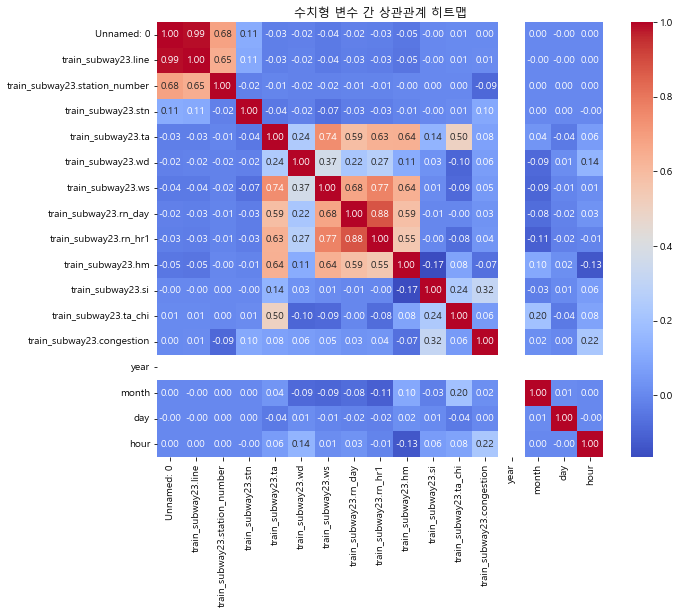

In [50]:
# 수치형 변수 간 상관관계 히트맵
df_numeric = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("수치형 변수 간 상관관계 히트맵")
plt.show()

다중공선성: (일 강수량, 1h 강수량)-0.88

강한 상관관계(+): (기온, 풍속), (기온, 일강수량), (기온, 1h강수량), (기온, 상대습도), (기온, 체감온도), (풍속, 일강수량), (풍속, 1h강수량), (풍속, 상대습도), (일강수량, 상대습도), (1h강수량, 상대습도)

중간 상관관계(+): (풍향, 풍속), (일조량, 혼잡도)

약한 상관관계(+): (일시, 체감온도), (기온, 풍향), (풍향, 일강수량), (풍향, 1h강수량), (기온, 상대습도), (풍속, 상대습도), (일조량, 체감온도)

약한 상관관계(-): (일시, 1h강수량), (상대습도, 일조량)

**강한 상관관계: |0.5| 이상
**중간 상관관계: |0.3|-|0.5|
**약한 상관관계(+): |0.15|-|0.3|
**unnamed:0 제외



In [51]:
df['train_subway23.line'].value_counts()

1    949872
7    810263
4    779688
5    749111
2    672672
3    672671
6    611520
8    275184
Name: train_subway23.line, dtype: int64

In [52]:
df['train_subway23.direction'].value_counts()

하선    2424155
상선    2424154
내선     336336
외선     336336
Name: train_subway23.direction, dtype: int64

In [53]:
df['train_subway23.station_name'].value_counts()

종로3가         45864
동대문역사문화공원    45864
서울역          30576
왕십리          30576
공덕           30576
             ...  
석남           15287
경복궁          15287
전곡             672
청산             672
연천             672
Name: train_subway23.station_name, Length: 324, dtype: int64

<AxesSubplot:xlabel='train_subway23.ta', ylabel='Count'>

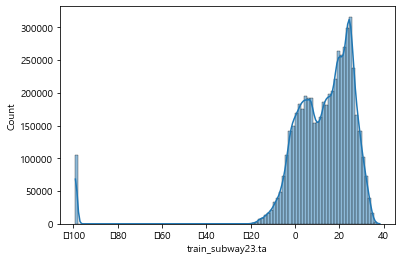

In [54]:
sns.histplot(data=df, x="train_subway23.ta", bins=100, kde=True)

In [55]:
df['train_subway23.congestion'].value_counts()

0      491909
18     121068
17     120590
15     120325
16     120311
        ...  
228        13
210        13
219        10
229         8
231         2
Name: train_subway23.congestion, Length: 232, dtype: int64

In [56]:
pop_st=[ '가산디지털단지',
 '강남',
 '고속터미널',
 '구로디지털단지',
 '명동',
 '사당',
 '삼성(무역센터)',
 '서울대입구(관악구청)',
 '서울역',
 '선릉',
 '성수',
 '수원',
 '신도림',
 '신림',
 '여의나루',
 '역삼',
 '영등포',
 '용산',
 '을지로입구',
 '잠실(송파구청)',
 '종각',
 '혜화',
 '홍대입구']
df['pop_st'] = df['train_subway23.station_name'].apply(lambda x: 1 if x in pop_st else 0)
df

,Unnamed: 0,train_subway23.tm,train_subway23.line,train_subway23.station_number,train_subway23.station_name,train_subway23.direction,train_subway23.stn,train_subway23.ta,train_subway23.wd,train_subway23.ws,...,train_subway23.rn_hr1,train_subway23.hm,train_subway23.si,train_subway23.ta_chi,train_subway23.congestion,year,month,day,hour,pop_st
0,1,2023010100,1,150,서울역,상선,419,0.3,318.0,3.4,...,0.0,66.5,-99.0,0.7,0,2023,1,1,0,1
1,2,2023010101,1,150,서울역,상선,419,0.6,293.8,3.4,...,0.0,67.5,-99.0,-0.6,0,2023,1,1,1,1
2,3,2023010105,1,150,서울역,상선,419,-0.8,29.6,3.7,...,0.0,55.1,-99.0,-2.2,3,2023,1,1,5,1
3,4,2023010106,1,150,서울역,상선,419,-1.8,48.1,3.4,...,0.0,62.8,-99.0,-4.0,6,2023,1,1,6,1
4,5,2023010107,1,150,서울역,상선,419,-2.6,21.4,2.9,...,0.0,68.8,-99.0,-2.8,5,2023,1,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520976,5520977,2023123119,8,2828,남위례,하선,572,0.6,0.0,0.0,...,0.0,83.1,-99.0,0.0,18,2023,12,31,19,0
5520977,5520978,2023123120,8,2828,남위례,하선,572,0.0,354.7,0.0,...,0.0,84.7,-99.0,-0.6,17,2023,12,31,20,0
5520978,5520979,2023123121,8,2828,남위례,하선,572,-0.6,0.0,0.0,...,0.0,85.1,-99.0,-1.1,21,2023,12,31,21,0
5520979,5520980,2023123122,8,2828,남위례,하선,572,-0.8,0.0,0.0,...,0.0,85.6,-99.0,-1.3,18,2023,12,31,22,0


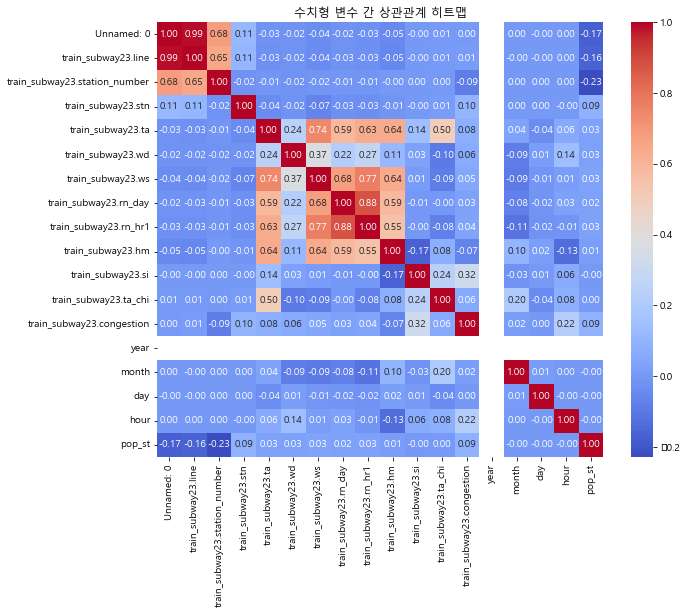

In [57]:
# 수치형 변수 간 상관관계 히트맵
df_numeric = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("수치형 변수 간 상관관계 히트맵")
plt.show()

In [58]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 타겟 변수
target = "train_subway23_congestion"

# 피처 이름에서 특수문자(.)를 밑줄(_)로 교체
df.columns = df.columns.str.replace(r"[^\w]", "_", regex=True)

# 특성: 타겟을 제외한 수치형 변수 전부 사용
features = df.select_dtypes(include=["int64", "float64"]).drop(columns=[target]).columns.tolist()

# 결측치 처리
X = df[features].fillna(-999)
y = df[target]

# 학습/검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 및 학습
model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_val)

# 성능 평가
import numpy as np
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2388
[LightGBM] [Info] Number of data points in the train set: 4416784, number of used features: 17
[LightGBM] [Info] Start training from score 25.288551
RMSE: 13.3413
R^2 Score: 0.6011


In [59]:
# 방학 월: 1, 2, 7, 8 → 0 / 나머지 → 1
df['vacation'] = df['month'].apply(lambda x: 0 if x in [1, 2, 7, 8] else 1)

# 출퇴근 시간: 07, 08, 09, 17, 18, 19 → 1 / 나머지 → 0
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if x in [7, 8, 9, 17, 18, 19] else 0)

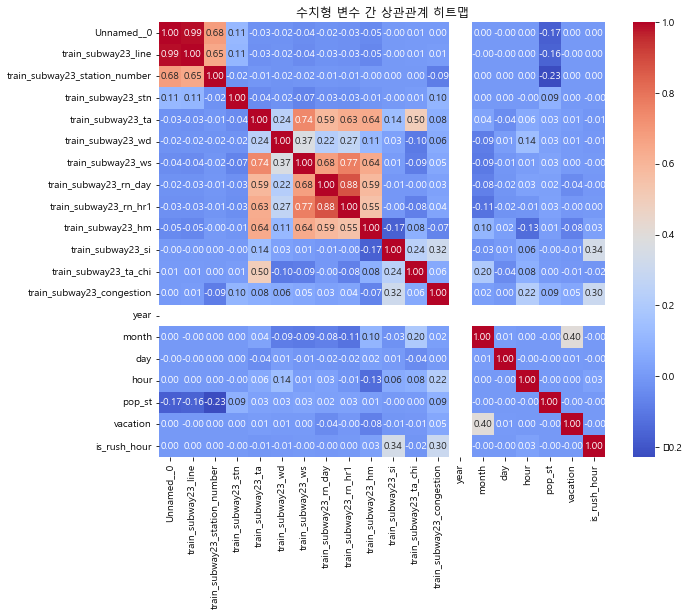

In [60]:
# 수치형 변수 간 상관관계 히트맵
df_numeric = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("수치형 변수 간 상관관계 히트맵")
plt.show()

# 전처리(다중공선성 고려 변수 줄이기)
1. 다중공선성 문제
    1) 일 강수량 /1h 강수량 -> 하나만 고려하기 (0.88의 상관관계 -> 거의 겹침, 하나 제거하기?)
    2) 역 번호, 호선 데이터 아예 삭제(연관 없어보임)
    3) 기온: (풍속 - 0.74), (1h 강수량 - 0.63), (상대습도 - 0.64)
    4) 풍속: (일 강수량 - 0.68), (1h 강수량 - 0.77), (
    5) 
2. 파생변수 추가
    1) 출퇴근 시간대 이진 변수(출퇴근 시간대=1, 나머지 0) -> 혼잡도와 상관계수 0.3
    2) 방학 여부(1,2,7,8)월= 별 영향 없기에 그대로 삭제해도 될 것 같습니다
    3) 기타 year, month, hour, day도 삭제해도 무방할 것 같습니다.

In [61]:
# 제거 대상 변수 목록
drop_columns = [
    'Unnamed_0',
    'train_subway23_line',
    'train_subway23_station_number',
    'year',
    'month',
    'day',
    'hour',
    'vacation',
    'train_subway23_rn_day'  # 일 강수량 (1h 강수량 유지)
]

# 제거 수행
df = df.drop(columns=drop_columns, errors='ignore')  # errors='ignore'는 컬럼 없으면 무시
df.head()

,Unnamed__0,train_subway23_tm,train_subway23_station_name,train_subway23_direction,train_subway23_stn,train_subway23_ta,train_subway23_wd,train_subway23_ws,train_subway23_rn_hr1,train_subway23_hm,train_subway23_si,train_subway23_ta_chi,train_subway23_congestion,pop_st,is_rush_hour
0,1,2023010100,서울역,상선,419,0.3,318.0,3.4,0.0,66.5,-99.0,0.7,0,1,0
1,2,2023010101,서울역,상선,419,0.6,293.8,3.4,0.0,67.5,-99.0,-0.6,0,1,0
2,3,2023010105,서울역,상선,419,-0.8,29.6,3.7,0.0,55.1,-99.0,-2.2,3,1,0
3,4,2023010106,서울역,상선,419,-1.8,48.1,3.4,0.0,62.8,-99.0,-4.0,6,1,0
4,5,2023010107,서울역,상선,419,-2.6,21.4,2.9,0.0,68.8,-99.0,-2.8,5,1,1


In [62]:
# 1. train_subway23_direction에서 상선=0, 하선=1 라벨인코딩
# 2. Unnamed__0, train_subway23_tm 삭제
# 3. train_subway23_wd에서 -99와 -9.9를 결측값으로 바꾸고, 다시 평균값으로 대체.
# 4. 이후 4방향으로 0, 1, 2, 3 라벨 인코딩


In [63]:
# 이상값을 결측치로 처리
df['train_subway23_wd'] = df['train_subway23_wd'].replace([-99, -9.9], np.nan)

# 결측값을 평균으로 대체
mean_wd = df['train_subway23_wd'].mean()
df['train_subway23_wd'] = df['train_subway23_wd'].fillna(mean_wd)

In [64]:
def encode_wind_direction_4(wd):
    if (wd >= 315 or wd < 45):
        return 'N'
    elif 45 <= wd < 135:
        return 'E'
    elif 135 <= wd < 225:
        return 'S'
    else:  # 225 <= wd < 315
        return 'W'

df['wind_dir_4'] = df['train_subway23_wd'].apply(encode_wind_direction_4)
df = df.drop(columns='train_subway23_wd')


In [65]:
df = df.drop(columns=['train_subway23_tm','Unnamed__0'])
df.head()

,train_subway23_station_name,train_subway23_direction,train_subway23_stn,train_subway23_ta,train_subway23_ws,train_subway23_rn_hr1,train_subway23_hm,train_subway23_si,train_subway23_ta_chi,train_subway23_congestion,pop_st,is_rush_hour,wind_dir_4
0,서울역,상선,419,0.3,3.4,0.0,66.5,-99.0,0.7,0,1,0,N
1,서울역,상선,419,0.6,3.4,0.0,67.5,-99.0,-0.6,0,1,0,W
2,서울역,상선,419,-0.8,3.7,0.0,55.1,-99.0,-2.2,3,1,0,N
3,서울역,상선,419,-1.8,3.4,0.0,62.8,-99.0,-4.0,6,1,0,E
4,서울역,상선,419,-2.6,2.9,0.0,68.8,-99.0,-2.8,5,1,1,N


In [66]:
df.head()

,train_subway23_station_name,train_subway23_direction,train_subway23_stn,train_subway23_ta,train_subway23_ws,train_subway23_rn_hr1,train_subway23_hm,train_subway23_si,train_subway23_ta_chi,train_subway23_congestion,pop_st,is_rush_hour,wind_dir_4
0,서울역,상선,419,0.3,3.4,0.0,66.5,-99.0,0.7,0,1,0,N
1,서울역,상선,419,0.6,3.4,0.0,67.5,-99.0,-0.6,0,1,0,W
2,서울역,상선,419,-0.8,3.7,0.0,55.1,-99.0,-2.2,3,1,0,N
3,서울역,상선,419,-1.8,3.4,0.0,62.8,-99.0,-4.0,6,1,0,E
4,서울역,상선,419,-2.6,2.9,0.0,68.8,-99.0,-2.8,5,1,1,N


In [67]:
df['direction_label'] = df['train_subway23_direction'].map({'상선': 0, '하선': 1})
df=df.drop(columns='train_subway23_direction')
df.head()

,train_subway23_station_name,train_subway23_stn,train_subway23_ta,train_subway23_ws,train_subway23_rn_hr1,train_subway23_hm,train_subway23_si,train_subway23_ta_chi,train_subway23_congestion,pop_st,is_rush_hour,wind_dir_4,direction_label
0,서울역,419,0.3,3.4,0.0,66.5,-99.0,0.7,0,1,0,N,0.0
1,서울역,419,0.6,3.4,0.0,67.5,-99.0,-0.6,0,1,0,W,0.0
2,서울역,419,-0.8,3.7,0.0,55.1,-99.0,-2.2,3,1,0,N,0.0
3,서울역,419,-1.8,3.4,0.0,62.8,-99.0,-4.0,6,1,0,E,0.0
4,서울역,419,-2.6,2.9,0.0,68.8,-99.0,-2.8,5,1,1,N,0.0


In [68]:
df['wd_4'] = df['wind_dir_4'].map({'N': 0, 'E': 1, 'S': 2, 'W': 3})
df=df.drop(columns='wind_dir_4')
df.head()

,train_subway23_station_name,train_subway23_stn,train_subway23_ta,train_subway23_ws,train_subway23_rn_hr1,train_subway23_hm,train_subway23_si,train_subway23_ta_chi,train_subway23_congestion,pop_st,is_rush_hour,direction_label,wd_4
0,서울역,419,0.3,3.4,0.0,66.5,-99.0,0.7,0,1,0,0.0,0
1,서울역,419,0.6,3.4,0.0,67.5,-99.0,-0.6,0,1,0,0.0,3
2,서울역,419,-0.8,3.7,0.0,55.1,-99.0,-2.2,3,1,0,0.0,0
3,서울역,419,-1.8,3.4,0.0,62.8,-99.0,-4.0,6,1,0,0.0,1
4,서울역,419,-2.6,2.9,0.0,68.8,-99.0,-2.8,5,1,1,0.0,0


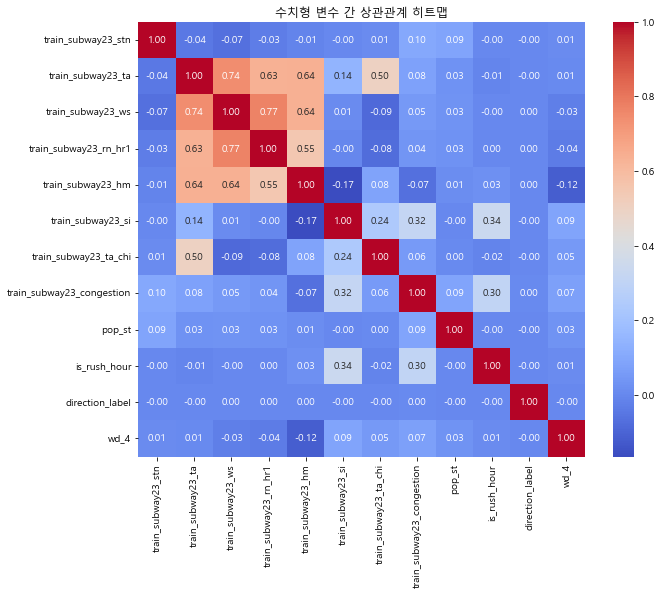

In [69]:
# 수치형 변수 간 상관관계 히트맵
df_numeric = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("수치형 변수 간 상관관계 히트맵")
plt.show()

In [70]:
# 상선/하선과 stn은 삭제해도 될 것 같다.

In [71]:
df.to_csv('output.csv', index=False, encoding='utf-8')